# Calculate SPI and SPEI indicators from various input datasets

## Use 20th Century (1901-2000) as calibration period for SPI distribution fit

## Datasets

CRU monthly rainfall and mean temperatures

ECMWF ERA Interim

- The base period from ERA Interim is rather short, so prefer CRU for now
- In theory it should be possible to use the distribution parameters calibrated from the long CRU to apply SPI calculation to the much shorter ECMWF ERA calculations

In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook
from numba import float64, int64, jit, prange


from precipitation_indices import indices, compute
import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC



In [2]:
SPI_OUT = DATA_SRC / 'lancet'
# SPI_OUT = WEATHER_SRC / 'cru'

In [3]:
# from dask.distributed import Client, Scheduler
# client = Client()
# client

In [4]:
@jit(nogil=True, parallel=True)
def spi_pearson_ufunc(precips_mm, months_scale, data_start_year, calibration_year_initial, calibration_year_final):
    spi_out = np.empty_like(precips_mm)
    for i in prange(precips_mm.shape[0]):
        for j in prange(precips_mm.shape[1]):
            p_mm = precips_mm[i,j,:]
            spi_out[i, j,:] = indices.spi_pearson(p_mm, months_scale,
                                                  data_start_year, 
                                                   calibration_year_initial, 
                                                   calibration_year_final)
    return spi_out


## Apply SPI calculation to CRU monthly precipitation data

In [5]:
cru_ppt = xr.open_mfdataset(str(WEATHER_SRC / 'cru/cru_ts4.01.1901.2016.*.dat.nc'), 
                        chunks={'lat':120, 'lon':60},
                        drop_variables=['stn', 'tmn'], engine='scipy', lock=False)

In [6]:
data_start_year = np.asscalar(cru_ppt['time.year'][0])
data_start_year

1901

In [7]:
spi3 = xr.apply_ufunc(indices.spi_gamma, cru_ppt.pre, 3,
                      input_core_dims=[['time'], []],
                      output_core_dims=[['time']], 
                      vectorize=True, dask='parallelized', 
                      output_dtypes=[np.float32])

In [1]:
spi3.to_netcdf( SPI_OUT / 'spi3_1901_2016_cru.nc')

In [6]:
# spi6 = xr.apply_ufunc(spi_pearson_ufunc,
#                       cru_ppt.pre, 6, data_start_year, 1901, 2000,
#                       input_core_dims=[['time'],[],[],[],[]], 
#                       output_core_dims=[['time']], 
# #                       vectorize=True,
#                       dask='parallelized', 
#                       output_dtypes=[np.float32])
# spi6.name = 'spi6'

In [3]:
# spi6.to_netcdf(SPI_OUT / 'spi6_pearson_1901_2016_cru.nc')

In [8]:
spi6 = xr.apply_ufunc(indices.spi_gamma,
                      cru_ppt.pre, 6, data_start_year, 1901, 2000,
                      input_core_dims=[['time'],[]], 
                      output_core_dims=[['time']], 
                      vectorize=True,
                      dask='parallelized', 
                      output_dtypes=[np.float32])
spi6.name = 'spi6'

In [9]:
spi6.to_netcdf(SPI_OUT/ 'spi6_1901_2016_cru.nc')

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)
/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  retur

In [14]:
spi12 = xr.apply_ufunc(indices.spi_gamma, cru_ppt.pre, 12,
                       input_core_dims=[['time'], []], 
                       output_core_dims=[['time']], 
                       vectorize=True, dask='parallelized', 
                       output_dtypes=[np.float32])
spi12.name = 'spi12'

In [15]:
spi12.to_netcdf(SPI_OUT / 'spi12_1901_2016_cru.nc')

## Apply SPI calculation to ECMWF monthly precipitation data

In [26]:
PPT_FOLDER = WEATHER_SRC / 'ecmwf'/ 'monthly_precipitation' / '*_precipitation.nc'
era_ppt = xr.open_mfdataset(str(PPT_FOLDER), 
                            engine='scipy', lock=False)

In [32]:
era_ppt = era_ppt.load()
era_ppt = era_ppt.chunk({'latitude':60, 'longitude':60, 'time': -1})

In [28]:
spi6 = xr.apply_ufunc(spi6_ufunc, era_ppt.tp, 
                      input_core_dims=[['time']], 
                      output_core_dims=[['time']], 
                      vectorize=True, dask='parallelized', output_dtypes=[np.float])
spi6.name = 'spi6'

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 

In [30]:
spi6.to_netcdf(DATA_SRC / 'lancet' / 'spi6_1980_2017_era.nc')

In [33]:
spi12 = xr.apply_ufunc(spi12_ufunc, era_ppt.tp, 
                      input_core_dims=[['time']],
                      output_core_dims=[['time']], 
                      vectorize=True, 
                       dask='parallelized', 
                       output_dtypes=[np.float])
spi12.name = 'spi12'

In [34]:
spi12.to_netcdf(DATA_SRC / 'lancet' / 'spi12_1980_2017_era.nc')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 

# Calculate SPEI

## Apply SPEI calculation to CRU monthly precipitation data

In [6]:
# -------------------------------------------------------
# Manually ufunc'ed versions of SPEI index calculations
# -------------------------------------------------------
# @jit(nogil=True, parallel=True)
def spei_ufunc(precips_mm, temperatures, lat, months_scale):
#     import numpy as np
#     from precipitation_indices import indices, compute
    
    spei_out = np.empty_like(precips_mm)
    for i in range(precips_mm.shape[0]):
        latitude_degrees = lat[i]
        for j in range(precips_mm.shape[1]):
            p_mm = precips_mm[i, j, :]
            t_celsius = temperatures[i, j, :]
            spei_out[i, j,:] = indices.spei_gamma(p_mm, months_scale, temps_celsius=t_celsius, 
                                                  data_start_year=1901, latitude_degrees=latitude_degrees)
    return spei_out


# @jit(nogil=True, parallel=True)
def spei3_ufunc(precips_mm, temperatures, lat):
    return spei_ufunc(precips_mm, temperatures, lat, 3)


# @jit(nogil=True, parallel=True)
def spei6_ufunc(precips_mm, temperatures, lat):
    return spei_ufunc(precips_mm, temperatures, lat, 6)


# @jit(nogil=True, parallel=True)
def spei12_ufunc(precips_mm, temperatures, lat):
    return spei_ufunc(precips_mm, temperatures, lat, 12)



In [ ]:
spei3 = xr.apply_ufunc(spei3_ufunc, cru_ppt.pre, cru_ppt.tmp, cru_ppt.lat, 
                       input_core_dims=[['time'],['time'],[]],
                       output_core_dims=[['time']], 
                       dask='parallelized', 
                       output_dtypes=[np.float32])

In [ ]:
spei3.to_netcdf(DATA_SRC / 'lancet' / 'spei3_1901_2016_cru.nc')

In [ ]:
spei6 = xr.apply_ufunc(spei6_ufunc, cru_ppt.pre, cru_ppt.tmp, cru_ppt.lat, 
                       input_core_dims=[['time'],['time'],[]],
                       output_core_dims=[['time']], 
                       dask='parallelized', 
                       output_dtypes=[np.float32])

In [ ]:
spei6.to_netcdf(DATA_SRC / 'lancet' / 'spei6_1901_2016_cru.nc')

In [7]:
spei12 = xr.apply_ufunc(spei12_ufunc, cru_ppt.pre, cru_ppt.tmp, cru_ppt.lat, 
                       input_core_dims=[['time'],['time'],[]],
                       output_core_dims=[['time']], 
                       dask='parallelized', 
                       output_dtypes=[np.float32])

In [8]:
spei12.to_netcdf(DATA_SRC / 'lancet' / 'spei12_1901_2016_cru.nc')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 

# Open and test/compare some of the results

In [7]:
spi_ncar = xr.open_dataset(WEATHER_SRC/ 'spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc')

spi6_gamma = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_1901_2016_cru.nc',
                               chunks={'lat':60, 'lon': 60}
                            )
# SPI pearson is callibrated on 20th century data
spi6_pearson = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_pearson_1901_2016_cru.nc',
                               chunks={'lat':60, 'lon':60})

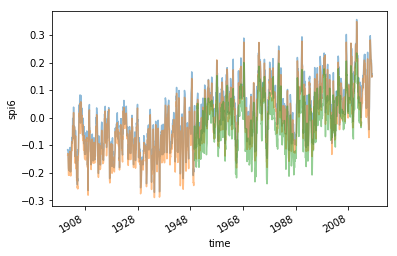

In [8]:
spi6_gamma.mean(dim=['lon','lat'], skipna=True).plot(alpha=0.5)
spi6_pearson.mean(dim=['lon','lat'], skipna=True).plot(alpha=0.5)
spi_ncar.spi6.mean(dim=['lon','lat'], skipna=True).plot(alpha=0.5)

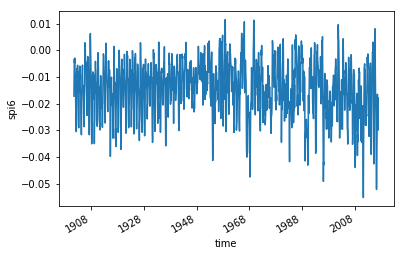

In [34]:
delta = (spi6_gamma - spi6_pearson)
delta_mean = delta.mean(dim=['lon','lat'], skipna=True)
delta_mean.plot()

In [36]:
delta_mean.mean().compute()

<xarray.DataArray 'spi6' ()>
array(-0.014546268410425252)

In [38]:
spi12_gamma = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi12_1901_2016_cru.nc',
                               chunks={'lat':60, 'lon': 60}
                            )


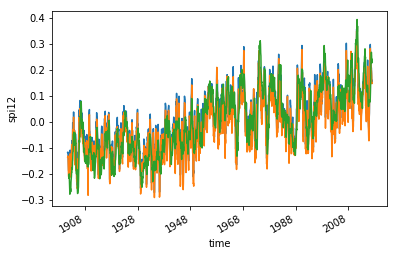

In [42]:
spi6_gamma.mean(dim=['lon','lat'], skipna=True).plot()
spi6_pearson.mean(dim=['lon','lat'], skipna=True).plot()

spi12_gamma.mean(dim=['lon','lat'], skipna=True).plot()


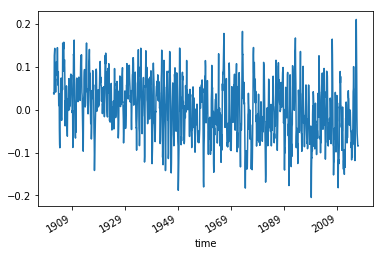

In [40]:
delta = (spi6_gamma - spi12_gamma)
delta_mean = delta.mean(dim=['lon','lat'], skipna=True)
delta_mean.plot()

In [41]:
delta_mean.mean().compute()

<xarray.DataArray ()>
array(0.0032649291679263115, dtype=float32)

#### Compare SPEI values

In [12]:
spei6= xr.open_dataarray(DATA_SRC / 'lancet' / 'spei6_1901_2016_cru.nc',
                               chunks={'lat':60, 'lon': 60}
                            )
# SPI pearson is callibrated on 20th century data
spei12 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spei12_1901_2016_cru.nc',
                               chunks={'lat':60, 'lon':60})

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


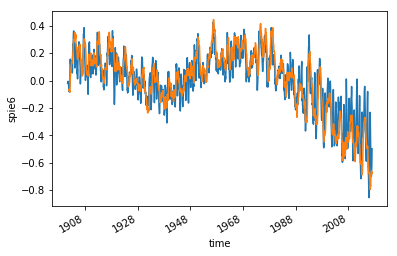

In [13]:
spei6.mean(dim=['lon','lat'], skipna=True).plot()
spei12.mean(dim=['lon','lat'], skipna=True).plot()